In [1]:
# [CLEAR VARIABLES]
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# RESOURCES
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
# https://www.youtube.com/watch?v=R-sQT9AB5cI&ab_channel=AIQCAR
# https://www.dataquest.io/blog/learning-curves-machine-learning/

# TODO: create feature that shows within a category, how much mony was spent in the last week/month
# TODO: create feature that shows ratio of successful/failed projects in the last month

# [IMPORT PACKAGES]
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import IPython as ip
from IPython import display as display
import seaborn as sns
import sklearn as sk
import random
import time

# [IMPORT DATA]
ks = pd.read_csv('ks2018.csv')
print("-"*100,'\nData set: {} samples'.format(ks.shape[0]))
print("-"*100)

# [NULL DATA]
print('Null values:')
print(ks.isnull().sum())
print("-"*100)
print('Percentage missing for "name" %.4f%%' %((ks['name'].isnull().sum()/ks.shape[0])*100))
print('Percentage missing for "usd pledged" %.4f%%' %((ks['usd pledged'].isnull().sum()/ks.shape[0])*100))
print("-"*100)

# [ANALYZE POSSIBLE OUTCOMES]
print('Outcomes: ', list(ks.state.unique()))
print("-"*100)

# [LIVE PROJECTS]
live = ks.apply(lambda x: True if x['state'] == 'live' else False , axis=1)
print('The amount of live projects is: ', len(live[live == True].index))
print('This is %.2f%% of the total projects' %((len(live[live == True].index)/ks.shape[0])*100))
print("-"*100)

pd.set_option('display.max_columns', None)

---------------------------------------------------------------------------------------------------- 
Data set: 378661 samples
----------------------------------------------------------------------------------------------------
Null values:
ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64
----------------------------------------------------------------------------------------------------
Percentage missing for "name" 0.0011%
Percentage missing for "usd pledged" 1.0027%
----------------------------------------------------------------------------------------------------
Outcomes:  ['failed', 'canceled', 'successful', 'live', 'undefined', 'suspended']
----

In [3]:
# DATA [CORRECTION, COMPLETION, CONVERSION, DELETION]

# remove live projects (0.74% of all data)
ks = ks.query('state != "live"')

# set state to 1 if successful, 0 otherwise, 1 is used for the 'rare class', there are more failed projects thant successful projects
ks['outcome'] = (ks['state'] == 'successful').astype(float)

# remove projects with null names (0.0011% of all data)
ks.drop(ks[ks.name.isnull()].index, axis=0, inplace=True, errors='ignore')

# remove outliers: goal over 30 000 000 (unrealistic, jokes)
ks.drop(ks[ks.goal > 30000000].index, inplace=True, errors='ignore')

# convert launched and deadline columns to datetime objects
ks['launched'] = pd.to_datetime(ks['launched'])
ks['deadline'] = pd.to_datetime(ks['deadline'])

# give unix-time anomalies a new launch date, 30 days before deadline (median, in order to not mess with data)
ks.loc[pd.DatetimeIndex(ks['launched']).year < 2000, 'launched'] = ks['deadline'] - pd.to_timedelta(30, unit='d')

# reduce size of dataset
ks = ks.sample(40000) 

print("-"*100,'\nNew data set: {} samples'.format(ks.shape[0]))
print("-"*100)

print(ks.head(5))



---------------------------------------------------------------------------------------------------- 
New data set: 40000 samples
----------------------------------------------------------------------------------------------------
                ID                                               name  \
192586   198003644                     Empanada Mama's Mobile Kitchen   
260634   395694644                                    Flu and Friends   
364180   925542527  Guidester | Custom Travel Guidebooks | Travel ...   
55347   1281637469                     Fill the World with "ONENESS!"   
234680   263004123  3 Free libraries Installation in Woodridge, IL...   

                category main_category currency   deadline     goal  \
192586       Food Trucks          Food      USD 2016-06-01   8700.0   
260634  Children's Books    Publishing      USD 2016-11-07   2000.0   
364180               Web    Technology      USD 2016-08-25  25000.0   
55347        World Music         Music      US

In [4]:
# FEATURE [CREATION, ENGINEERING]
from sklearn.preprocessing import LabelEncoder

# log transformation on goal column
ks['goal'] = np.log(ks.goal)

# create titlelength feature (length of the project name)
ks['tlength'] = ks['name'].str.len()

# create duration feature (campaign duration in days, rounded up)
ks['duration'] = ((ks['deadline'] - ks['launched']) / np.timedelta64(1, 'D')).round(0).astype(int)

# remove outliers: duration over 85
ks.drop(ks[ks.duration > 85].index, inplace=True, errors='ignore')

# create category_country feature (combination of category + country)
ks['category_country'] = ks['category'] + "_" + ks['country']

# create launch features (year, month [1,12], day of week [0,6], hour and is_weekend)
ks['lyear'] = pd.DatetimeIndex(ks['launched']).year
ks['lmonth'] = pd.DatetimeIndex(ks['launched']).month
ks['lday'] = pd.DatetimeIndex(ks['launched']).dayofweek
ks['lhour'] = pd.DatetimeIndex(ks['launched']).hour
ks["l_is_weekend"] = ks["lday"].apply(lambda x: 1 if x > 4 else 0)

# create deadline features (year, month [1,12] and day of week [0,6])
ks['dyear'] = pd.DatetimeIndex(ks['deadline']).year
ks['dmonth'] = pd.DatetimeIndex(ks['deadline']).month
ks['dday'] = pd.DatetimeIndex(ks['deadline']).dayofweek 

# create project_competition feature (number of projects launched in past week)
launches = pd.Series(ks.index, index=ks.launched, name="project_competition").sort_index()
project_competition = launches.rolling('7d').count() - 1 
project_competition.index = launches.values
ks['project_competition'] = project_competition.reindex(ks.index)

# create category_competition feature (time since last project in same category was launched)
def time_since_last_project(series): return series.diff().dt.total_seconds() / 3600.
df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
ks['category_competition'] = timedeltas.fillna(timedeltas.median()).reindex(ks.index)

# create success ratio feature (kickstarter success ratio during previous month)
df = ks[['outcome', 'deadline']].sort_values('deadline')
df['outcome'] = df['outcome'].astype(float)
df['sum_outcomes'] = df['outcome'].rolling(window=30).sum() - df['outcome'] 
df['count_outcomes'] = df['outcome'].rolling(window=30).count()
df['success_ratio'] = df['sum_outcomes']/df['count_outcomes']
ks['success_ratio'] = df['success_ratio'].fillna(df['success_ratio'].median()).reindex(ks.index)

# create money spent feature (how much money was already spent last month)
df = ks[['pledged', 'deadline']].sort_values('deadline')
df['sum_pledged'] = df['pledged'].rolling(window=30).sum() - df['pledged'] 
ks['money_spent'] = df['sum_pledged'].fillna(df['sum_pledged'].median()).reindex(ks.index)

print(ks.corr().abs()[['outcome']])

# transform category in multiple colums with one hot encoding, so it can be used to compute category related features
ks = pd.concat([ks, pd.get_dummies(ks["main_category"])], axis = 1)
le = LabelEncoder()
for c in ["category", "main_category"]:
    ks[c] = le.fit_transform(ks[c])

# create category related features
t2 = ks.groupby("main_category").agg({"goal" : "mean", "category" : "sum"})
t1 = ks.groupby("category").agg({"goal" : "mean", "main_category" : "sum"})
t2 = t2.reset_index().rename(columns={"goal" : "mean_main_category_goal", "category" : "main_category_count"})
t1 = t1.reset_index().rename(columns={"goal" : "mean_category_goal", "main_category" : "category_count"})
ks = ks.merge(t1, on = "category")
ks = ks.merge(t2, on = "main_category")

ks["diff_mean_category_goal"] = ks["mean_category_goal"] - ks["goal"]
ks["diff_mean_category_goal"] = ks["mean_main_category_goal"] - ks["goal"]

# create money spent feature
#def mony_spend_last_month():
    
#df = ks[['category', 'launched', 'deadline', 'usd pledged']].sort_values('launched')
#moneydeltas = df.groupby('category').transform(mony_spend_last_month)
#moneydeltas = moneydeltas.fillna(moneydeltas.median()).reindex(ks.index)

#ks['category_money'] = moneydeltas
#print(df)

# print result
print(ks)


                       outcome
ID                    0.003756
goal                  0.222951
pledged               0.138373
backers               0.105649
usd pledged           0.136425
usd_pledged_real      0.132680
usd_goal_real         0.048987
outcome               1.000000
tlength               0.058749
duration              0.130862
lyear                 0.091666
lmonth                0.011243
lday                  0.024078
lhour                 0.011453
l_is_weekend          0.020308
dyear                 0.094644
dmonth                0.008081
dday                  0.025621
project_competition   0.128080
category_competition  0.009531
success_ratio         0.110976
money_spent           0.008005
               ID                                               name  \
0       198003644                     Empanada Mama's Mobile Kitchen   
1      2144549613       Let's get Jeanie's Brownie Business started!   
2       713564102                                CHICKEN AND WAFFLES   

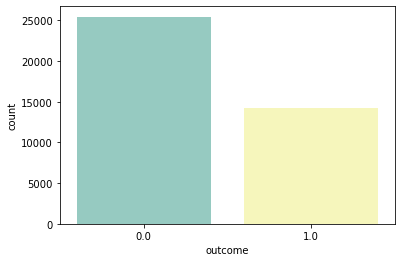

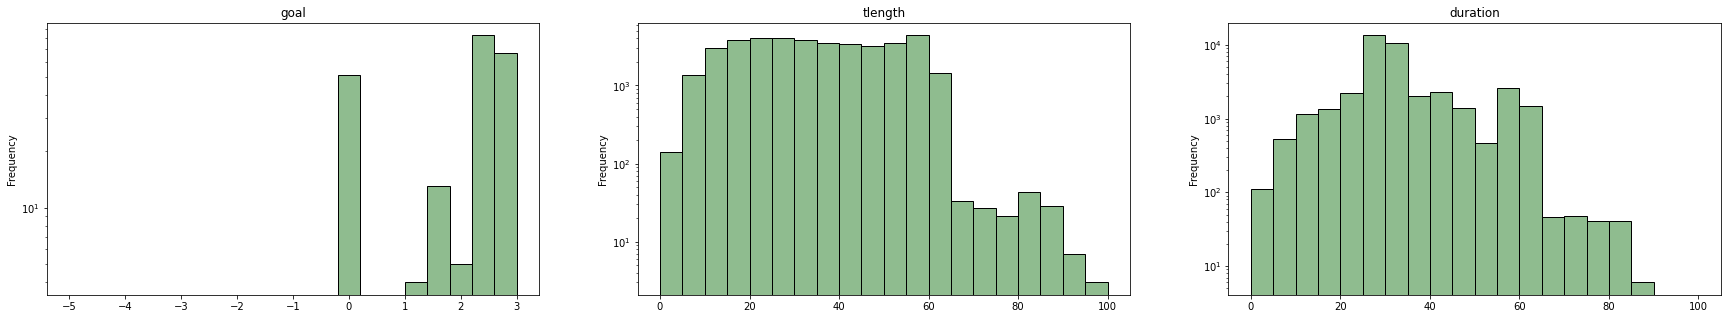

In [5]:
sns.countplot(x = 'outcome', data = ks, palette = 'Set3')


# FIND OUTLIERS
fig, axs = plt.subplots(ncols=3, figsize=(30,5))

# goal, kickstarter maximum is 100.000
axs[0].set_title("goal")
ks['goal'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[-5,3], ax=axs[0])

# tlength
axs[1].set_title("tlength")
ks['tlength'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[0,100], ax=axs[1])

# duration
axs[2].set_title("duration")
ks['duration'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[0,100], ax=axs[2])


plt.show()

In [6]:
# CATEGORICAL ENCODING (one-hot encoding, label encoding, count encoding, target encoding, catboost encoding)

from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

# categorical features to be encoded
# features = ['category', 'currency', 'country', 'category_country']
features = ['currency', 'country', 'category_country']

# encoders
l_encoder = LabelEncoder() # label encoding, encode target labels with value between 0 and n_classes-1.
c_encoder = ce.CountEncoder() # count encoding, replaces each categorical value with the number of times it appears in the dataset
t_encoder = ce.TargetEncoder(cols=features) # target encoding, replaces a categorical value with the average value of the target for that value of the feature
cb_encoder = ce.CatBoostEncoder(cols=features) # catboost encoding, for each row, the target probability is calculated only from the rows before it

# encoded features
l_encoded = ks[features].apply(l_encoder.fit_transform)
c_encoded = c_encoder.fit_transform(ks[features])
t_encoded = t_encoder.fit_transform(ks[features], ks['outcome'])
cb_encoded = cb_encoder.fit_transform(ks[features], ks['outcome'])

# create data set, drop colums of features that are not useful
ks.drop('currency', axis=1, inplace=True)
ks.drop('country', axis=1, inplace=True)
ks.drop('category_country', axis=1, inplace=True)
ks.drop('name', axis=1, inplace=True)
ks.drop('launched', axis=1, inplace=True)
ks.drop('deadline', axis=1, inplace=True)
ks.drop('usd pledged', axis=1, inplace=True)
ks.drop('state', axis=1, inplace=True)
#data = ks[['outcome', 'tlength', 'goal', 'duration', 'lyear', 'lmonth', 'lday', 'lhour', 'dyear', 'dmonth', 'dday', 'project_competition', 'category_competition']].join(t_encoded)
data = ks[['outcome', 'category', 'main_category', 'goal', 'duration', 'tlength', 'lyear', 'lmonth', 'lday', 'l_is_weekend', 'lhour', 'dyear', 'dmonth', 'dday', 'category_competition', 'project_competition', 'mean_category_goal', 'category_count', 'mean_main_category_goal', 'main_category_count', 'diff_mean_category_goal', 'category_competition']].join(t_encoded)
#data = ks.join(t_encoded)

# print result
print(data.head(5))

   outcome  category  main_category      goal  duration  tlength  lyear  \
0      0.0        59              7  9.071078        29       30   2016   
1      0.0        59              7  6.396930        29       44   2015   
2      0.0        59              7  5.298317        29       19   2014   
3      0.0        59              7  9.210340         6       11   2017   
4      1.0        59              7  6.907755        21       11   2016   

   lmonth  lday  l_is_weekend  lhour  dyear  dmonth  dday  \
0       5     0             0     18   2016       6     2   
1       4     1             0     18   2015       5     3   
2       9     4             0     22   2014      10     6   
3       3     1             0     22   2017       3     1   
4       8     5             1      4   2016       9     5   

   category_competition  project_competition  mean_category_goal  \
0             14.585278                120.0             9.62104   
1            192.205833                189.0  

In [7]:
# FEATURE SELECTION
from sklearn.tree import DecisionTreeClassifier

X = data.drop('outcome', axis = 1).values
y = data['outcome']
dt = DecisionTreeClassifier(random_state=15, criterion = 'entropy', max_depth = 10)
dt.fit(X,y)
fi_col = []
fi = []
for i,column in enumerate(data.drop('outcome', axis = 1)):
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])
fi_col
fi
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df = fi_df.sort_values('Feature Importance', ascending = False).reset_index()

# Creating columns to keep
columns_to_keep = fi_df['Feature'][0:10]

print(fi_df)

# feature selection
#data = data[['outcome', 'category', 'main_category', 'category_country', 'goal', 'duration', 'tlength', 'lyear', 'lmonth', 'lday', 'l_is_weekend', 'lhour', 'dyear', 'dmonth', 'dday', 'category_competition', 'project_competition', 'mean_category_goal', 'category_count', 'mean_main_category_goal', 'main_category_count', 'diff_mean_category_goal', 'category_competition']]

# correlations
#data.corr().abs()[['outcome']]


    index                  Feature  Feature Importance
0      23         category_country            0.432283
1      19  diff_mean_category_goal            0.120497
2       2                     goal            0.080983
3       3                 duration            0.078425
4      14      project_competition            0.051891
5       4                  tlength            0.034020
6       9                    lhour            0.032873
7      13     category_competition            0.018762
8       6                   lmonth            0.016249
9      20     category_competition            0.015309
10      7                     lday            0.014433
11      0                 category            0.012896
12     11                   dmonth            0.011931
13     15       mean_category_goal            0.010422
14     10                    dyear            0.009277
15      1            main_category            0.009129
16     12                     dday            0.009034
17      5 

In [8]:
# SCALE AND SPLIT DATA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# get predictors: goal, duration, project_competition, category, category_country
x_unscaled = data[['goal', 'duration', 'project_competition', 'category', 'category_country']]

# get outcome
y = data['outcome']

# feature scaling/normalizing
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x_unscaled), columns=list(x_unscaled.columns))


# split data into training, testing and validation set (60%, 20%, 20%)
# data -> training + testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

# training -> training + cross validation
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

print("-"*35)
print("[60%] x_train:\t", x_train.shape[0])
#print("[20%] x_valid:\t", x_valid.shape[0])
print("[20%] x_test:\t", x_test.shape[0])
print("-"*35)

# check if data is nicely spread
# https://imgur.com/a/cCCjKhj
# in the image above you see that the projects with outcome 1 are evenly spread among the sets

-----------------------------------
[60%] x_train:	 23831
[20%] x_test:	 15888
-----------------------------------


In [9]:
# LOGISTIC REGRESSION 
from numpy import mean, std
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve, KFold
from sklearn import metrics

# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# create model
model = LogisticRegression()

# evaluate model
scores = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


# create model
#model = LogisticRegression(C=0.01)

# fit model on training data set
model.fit(x_train, y_train)

# test model on cross validation data set
#y_pred_valid = model.predict(x_valid) 


# model score: score(test samples, true labels for x)
print("-"*60)
print("Logistic Regression Model Scores")
#print('[TRAIN]\t %.2f%%' %(round(model.score(x_train, y_train),5)*100))
#print('[VALID]\t %.2f%%' %(round(model.score(x_valid, y_valid),5)*100))
print('[TEST]\t %.2f%%' %(round(model.score(x_test, y_test),5)*100))
y_pred_test = model.predict(x_test) 
print("-"*60)

# classification report: classification_report(y_true, y_pred)
print("Classification Report")
print(classification_report(y_test, y_pred_test))
print("-"*60)


Accuracy: 0.705 (0.008)
------------------------------------------------------------
Logistic Regression Model Scores
[TEST]	 69.65%
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.73      0.85      0.78     10206
         1.0       0.61      0.43      0.50      5682

    accuracy                           0.70     15888
   macro avg       0.67      0.64      0.64     15888
weighted avg       0.68      0.70      0.68     15888

------------------------------------------------------------


In [10]:
# CONFUSION MATRIX LOGISTIC REGRESSION
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.YlGnBu):
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            size="20")
           
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# confusion matrix: confusion_matrix(y_true, y_pred)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred_valid)
np.set_printoptions(precision=2)
class_names = ['Successful', 'Failed']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

# evaluation of confusion matrix
print("-"*60)
print('[ACCURACY]\t %.2f%%' %(metrics.accuracy_score(y_valid, y_pred_valid)*100))
print('[PRECISION]\t %.2f%%' %(metrics.precision_score(y_valid, y_pred_valid)*100))
print('[RECALL]\t %.2f%%' %(metrics.recall_score(y_valid, y_pred_valid)*100))
print("-"*60)


NameError: name 'y_valid' is not defined

In [ ]:
y_pred_proba_train = model.predict_proba(x_train) # training
y_pred_proba_test = model.predict_proba(x_test) # testing
y_pred_proba_valid = model.predict_proba(x_valid) # validation

# Running Log loss on training
print("The Log Loss on Training is: ", metrics.log_loss(y_train, y_pred_proba_train))
print("The Log Loss on Testing Dataset is: ", metrics.log_loss(y_test, y_pred_proba_test))

# RECEIVER OPERATING CHARACTERISTIC (ROC) CURVE: roc_curve(y_true, y_score)
print("ROC Curve")
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print("Test AUC score: {auc}")
print("-"*60)




In [ ]:
# learning curve for when using whole dataset
# train_sizes, train_scores, validation_scores = learning_curve(estimator = LogisticRegression(), X=x_train, y=y_train, train_sizes = [500, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 1000, 15000, 20000, 25000, 25000, 30000, 35000, 40000, 45000, 50000], cv = 5)
# learning curve for when using part of dataset
train_sizes, train_scores, validation_scores = learning_curve(estimator = LogisticRegression(), X=x_train, y=y_train, train_sizes = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], cv = 5)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a logistic regression model', fontsize = 18, y = 1.03)
plt.legend()
#plt.ylim(0.68,0.703)


In [ ]:
# Optimal C/lambda value
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, random_state=0, shuffle=True)

C_List = np.geomspace(1e-5, 1e5, num=20)

# Logistic Reg CV
Log_reg3 = LogisticRegressionCV(random_state=15, Cs = C_List, solver ='lbfgs')
Log_reg3.fit(x_train, y_train)
print("The CA is:", Log_reg3.score(x_test, y_test))
pred_proba_t = Log_reg3.predict_proba(x_test)
log_loss3 = metrics.log_loss(y_test, pred_proba_t)
print("The Logistic Loss is: ", log_loss3)

print("The optimal C parameter is: ", Log_reg3.C_)


#C_List = np.geomspace(1e-5, 1e5, num=20)
CA = []
Logarithmic_Loss = []

for c in C_List:
    log_reg2 = LogisticRegression(random_state=10, solver = 'lbfgs', C=c)
    log_reg2.fit(x_train, y_train)
    score = log_reg2.score(x_test, y_test)
    CA.append(score)
    print("The CA of C parameter {} is {}:".format(c, score))
    pred_proba_t = log_reg2.predict_proba(x_test)
    log_loss2 = metrics.log_loss(y_test, pred_proba_t)
    Logarithmic_Loss.append(log_loss2)
    print("The Logg Loss of C parameter {} is {}:".format(c, log_loss2))
    print("")
    
    y_pred = log_reg2.predict(x_train)
    cm = metrics.confusion_matrix(y_train, y_pred)
    #cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
    plot_confusion_matrix(cm, normalize=True, classes = model.classes_, title='Confusion matrix', cmap=plt.cm.YlGnBu)
    plt.show()




In [ ]:
# DON'T EXECUTE! crashte bij mij idk waarom
# LightGBM
# Tree-based model that typically provides the best performance, even compared to XGBoost. It's also relatively fast to train.

import lightgbm as lgb
from sklearn import metrics

feature_cols = data.columns.drop('outcome')

dtrain = lgb.Dataset(data[feature_cols], label=data['outcome'])
dvalid = lgb.Dataset(data[feature_cols], label=data['outcome'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['outcome'], ypred)

# evaluation
print("-"*60)
print('Aread Under Curve (AUC): %.2f%%' %(metrics.roc_auc_score(test['outcome'], ypred)*100))
print("-"*60)

#76.06 (catboost)
#76.83 (target)
#76.34 (count)
#76.33 (label)


In [ ]:
# NAIVE BAYES ALGORITHM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn import metrics

# instantiate logistic regression model
model = GaussianNB()

# fit the model with the data
model.fit(x_train,y_train)

# make predictions
predict_test = model.predict(x_test)

# evaluation
print("-"*60)
print('Accuracy: %.2f%%' %(metrics.accuracy_score(y_test, predict_test)*100))
print('Precision: %.2f%%' %(metrics.precision_score(y_test, predict_test)*100))
print('Recall: %.2f%%' %(metrics.recall_score(y_test, predict_test)*100))
print("-"*60)


In [ ]:
# NEURAL NETWORK
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()

model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))

#model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
#model.fit(x_train, y_train, batch_size=32, epochs=50)

#model.summary()

#y_pred = model.predict_classes(x_test)
#print(metrics.accuracy_score(y_test, y_pred))



In [12]:
# SUPORRT VECTOR MACHINES
from sklearn import svm
from sklearn import metrics
from numpy import mean, std
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve, KFold

# Split dataset in train, validate, test sets
# x_train, x_valid, x_test, y_train, y_valid, y_test

# Create a svm Classifier
clf = svm.SVC(kernel='rbf') # Linear Kernel, or radial basis function?

# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)

# evaluate model
scores = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


# Train the model using the training sets
clf.fit(x_train, y_train)

# model score: score(test samples, true labels for x)
print("-"*60)
print("Support Vector Machines Model Scores")
print('[TRAIN]\t %.2f%%' %(round(clf.score(x_train, y_train),5)*100))
#print('[VALID]\t %.2f%%' %(round(clf.score(x_valid, y_valid),5)*100))
print('[TEST]\t %.2f%%' %(round(clf.score(x_test, y_test),5)*100))
y_pred_test_SVM = clf.predict(x_test) 
print("-"*60)

# classification report: classification_report(y_true, y_pred)
print("Classification Report")
print(classification_report(y_test, y_pred_test_SVM))
print("-"*60)

# evaluationg the model
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred_valid))
#print("Precision:",metrics.precision_score(y_test, y_pred_valid))
#print("Recall:",metrics.recall_score(y_test, y_pred_valid))

Accuracy: 0.706 (0.006)
------------------------------------------------------------
Support Vector Machines Model Scores
[TRAIN]	 70.80%
[TEST]	 69.83%
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.72      0.87      0.79     10206
         1.0       0.62      0.39      0.48      5682

    accuracy                           0.70     15888
   macro avg       0.67      0.63      0.63     15888
weighted avg       0.69      0.70      0.68     15888

------------------------------------------------------------


In [ ]:
# CONFUSION MATRIX SVM

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.YlGnBu):
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            size="20")
           
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# confusion matrix: confusion_matrix(y_true, y_pred)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred_valid)
np.set_printoptions(precision=2)
class_names = ['Successful', 'Failed']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

# evaluation of confusion matrix
print("-"*60)
print('[ACCURACY]\t %.2f%%' %(metrics.accuracy_score(y_valid, y_pred_valid_SVM)*100))
print('[PRECISION]\t %.2f%%' %(metrics.precision_score(y_valid, y_pred_valid_SVM)*100))
print('[RECALL]\t %.2f%%' %(metrics.recall_score(y_valid, y_pred_valid_SVM)*100))
print("-"*60)